# Tensorflow Basic Regression


In [343]:
import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.svm import SVR

In [344]:
df_original = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data",
    names=[
        "mpg",
        "cylinders",
        "displacement",
        "horsepower",
        "weight",
        "acceleration",
        "model_year",
        "origin",
    ],
    na_values="?",
    comment="\t",
    sep=" ",
    skipinitialspace=True,
)

df = df_original.copy()

df.sample(n=10)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
272,23.8,4,151.0,85.0,2855.0,17.6,78,1
244,43.1,4,90.0,48.0,1985.0,21.5,78,2
335,35.0,4,122.0,88.0,2500.0,15.1,80,2
304,37.3,4,91.0,69.0,2130.0,14.7,79,2
144,31.0,4,76.0,52.0,1649.0,16.5,74,3
230,15.5,8,350.0,170.0,4165.0,11.4,77,1
5,15.0,8,429.0,198.0,4341.0,10.0,70,1
59,23.0,4,97.0,54.0,2254.0,23.5,72,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
227,19.0,6,225.0,100.0,3630.0,17.7,77,1


In [345]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 25.0 KB


In [346]:
df.describe().round(2)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
count,398.00,398.00,398.00,392.00,398.00,398.00,398.00,398.00
mean,23.51,5.45,193.43,104.47,2970.42,15.57,76.01,1.57
std,7.82,1.70,104.27,38.49,846.84,2.76,3.70,0.80
min,9.00,3.00,68.00,46.00,1613.00,8.00,70.00,1.00
25%,17.50,4.00,104.25,75.00,2223.75,13.82,73.00,1.00
50%,23.00,4.00,148.50,93.50,2803.50,15.50,76.00,1.00
75%,29.00,8.00,262.00,126.00,3608.00,17.18,79.00,2.00
max,46.60,8.00,455.00,230.00,5140.00,24.80,82.00,3.00


array([[<Axes: title={'center': 'mpg'}>,
        <Axes: title={'center': 'cylinders'}>,
        <Axes: title={'center': 'displacement'}>],
       [<Axes: title={'center': 'horsepower'}>,
        <Axes: title={'center': 'weight'}>,
        <Axes: title={'center': 'acceleration'}>],
       [<Axes: title={'center': 'model_year'}>,
        <Axes: title={'center': 'origin'}>, <Axes: >]], dtype=object)

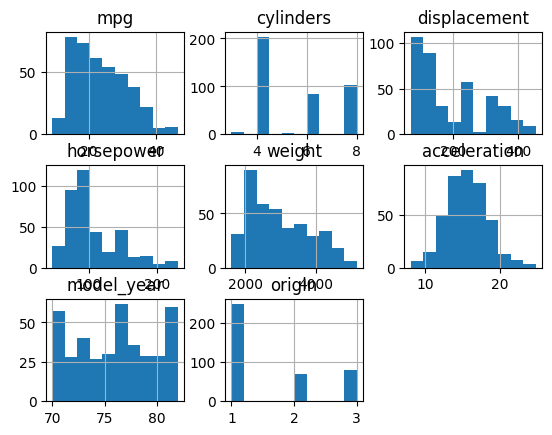

In [347]:
df.hist()

In [348]:
np.random.seed(42)

In [349]:
X, y = df.drop("mpg", axis=1), df["mpg"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
245,4,98.0,66.0,1800.0,14.4,78,1
110,4,108.0,94.0,2379.0,16.5,73,3
16,6,199.0,97.0,2774.0,15.5,70,1
66,8,304.0,150.0,3672.0,11.5,72,1
153,6,250.0,105.0,3459.0,16.0,75,1
...,...,...,...,...,...,...,...
71,3,70.0,97.0,2330.0,13.5,72,3
106,8,350.0,180.0,4499.0,12.5,73,1
270,4,134.0,95.0,2515.0,14.8,78,3
348,4,89.0,62.0,2050.0,17.3,81,3


In [350]:
cat_features = ["origin"]

num_features = [
    "cylinders",
    "displacement",
    "horsepower",
    "weight",
    "acceleration",
    "model_year",
]

In [351]:
imputer = ColumnTransformer(
    [
        (
            "imputer_cat",
            SimpleImputer(strategy="most_frequent", add_indicator=True),
            cat_features,
        ),
        (
            "imputer_num",
            SimpleImputer(strategy="median", add_indicator=True),
            num_features,
        ),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
)

In [352]:
scaler = ColumnTransformer(
    [
        ("scaler_num", MinMaxScaler(feature_range=(0, 1)), num_features),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
)

In [353]:
encoder = ColumnTransformer(
    [
        (
            "encoder_cat",
            OneHotEncoder(handle_unknown="ignore", sparse_output=False),
            cat_features,
        ),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
)

In [354]:
estimator = RandomForestRegressor()

In [355]:
pipeline = Pipeline(
    [
        ("imputer", imputer),
        ("scaler", scaler),
        ("encoder", encoder),
        ("estimator", estimator),
    ],
).set_output(transform="pandas")

pipeline.fit(X_train, y_train)

pipeline_score = pipeline.score(X_test, y_test)

print("------------------------------------------------------------")
print(f"Score: {pipeline_score.round(4)}")
print("------------------------------------------------------------")

------------------------------------------------------------
Score: 0.8829
------------------------------------------------------------


In [356]:
model = GridSearchCV(
    pipeline,
    {
        "estimator__max_features": [0.25, 0.5, 1],
        "estimator__min_samples_leaf": [1, 2, 4],
        "estimator__n_estimators": [50, 100, 200],
    },
    cv=5,
    verbose=2,
)

model.fit(X_train, y_train)

model_params = model.best_params_
model_score = model.score(X_test, y_test)

print("------------------------------------------------------------")
print(f"Parameters: {model_params}")
print(f"Score: {model_score.round(4)}")
print("------------------------------------------------------------")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END estimator__max_features=0.25, estimator__min_samples_leaf=1, estimator__n_estimators=50; total time=   0.0s
[CV] END estimator__max_features=0.25, estimator__min_samples_leaf=1, estimator__n_estimators=50; total time=   0.0s
[CV] END estimator__max_features=0.25, estimator__min_samples_leaf=1, estimator__n_estimators=50; total time=   0.0s
[CV] END estimator__max_features=0.25, estimator__min_samples_leaf=1, estimator__n_estimators=50; total time=   0.0s
[CV] END estimator__max_features=0.25, estimator__min_samples_leaf=1, estimator__n_estimators=50; total time=   0.0s
[CV] END estimator__max_features=0.25, estimator__min_samples_leaf=1, estimator__n_estimators=100; total time=   0.0s
[CV] END estimator__max_features=0.25, estimator__min_samples_leaf=1, estimator__n_estimators=100; total time=   0.0s
[CV] END estimator__max_features=0.25, estimator__min_samples_leaf=1, estimator__n_estimators=100; total time=   0.0s

In [357]:
best_estimator = RandomForestRegressor(
    max_features=model_params["estimator__max_features"],
    min_samples_leaf=model_params["estimator__min_samples_leaf"],
    n_estimators=model_params["estimator__n_estimators"],
)

best_model = Pipeline(
    [
        ("imputer", imputer),
        ("encoder", encoder),
        ("scaler", scaler),
        ("estimator", best_estimator),
    ],
)

scores = {
    "mae": cross_val_score(
        best_model,
        X,
        y,
        cv=5,
        scoring="neg_mean_absolute_error",
    ).mean(),
    "mse": cross_val_score(
        best_model,
        X,
        y,
        cv=5,
        scoring="neg_mean_squared_error",
    ).mean(),
    "msle": cross_val_score(
        best_model,
        X,
        y,
        cv=5,
        scoring="neg_mean_squared_log_error",
    ).mean(),
    "r2": cross_val_score(
        best_model,
        X,
        y,
        cv=5,
        scoring="r2",
    ).mean(),
    "mape": cross_val_score(
        best_model,
        X,
        y,
        cv=5,
        scoring="neg_mean_absolute_percentage_error",
    ).mean(),
}

print("------------------------------------------------------------")
print(f"Mean Absolute Error: {abs(scores['mae'].round(4))}")
print(f"Mean Squared Error: {abs(scores['mse'].round(4))}")
print(f"Mean Squared Log Error: {abs(scores['msle'].round(4))}")
print(f"R Squared: {abs(scores['r2'].round(4))}")
print(f"Mean Absolute Percentage Error: {abs(scores['mape'].round(4))}")
print("------------------------------------------------------------")

------------------------------------------------------------
Mean Absolute Error: 2.1576
Mean Squared Error: 9.495
Mean Squared Log Error: 0.0141
R Squared: 0.7482
Mean Absolute Percentage Error: 0.0926
------------------------------------------------------------
